In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import time
import urllib
from IPython import display
import tensorflow_docs.vis.embed as embed

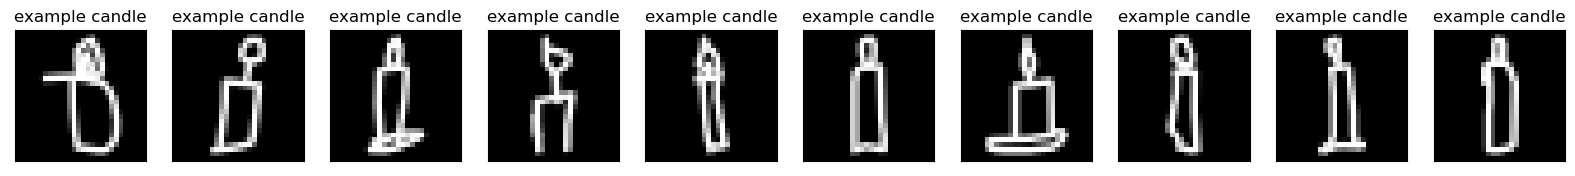

In [2]:
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
category = 'candle'

# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
 
# url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
# urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')

# You can limit the amount of images you use for training by setting :
train_images = images[:]

# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]
def reshape(data):
  return np.reshape(data, (data.shape[0], 28, 28, 1))

train_images = reshape(train_images)

# plot examples
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("example candle")
    plt.imshow(tf.squeeze(train_images[:][i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

BUFFER_SIZE = 10000
BATCH_SIZE = 256
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 10

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def normalize(data):
  return data.map(lambda x: ((tf.cast(x, tf.float32)/128.)-1.), num_parallel_calls=tf.data.AUTOTUNE)

train_ds= normalize(tf.data.Dataset.from_tensor_slices(train_images)).shuffle(BUFFER_SIZE).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [3]:
discriminator = tf.keras.Sequential([        

    tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3), 

    tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),    

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
    ])
        

generator = tf.keras.Sequential([

    tf.keras.layers.Dense(7*7*32, use_bias=False, input_shape=(noise_dim,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, 32)),

    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    
    tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation="tanh"),
    ])

generator_optimizer = tf.keras.optimizers.Adam()
discriminator_optimizer = tf.keras.optimizers.Adam()
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = bce(tf.ones_like(real_output), real_output)
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(20, 2))
  # predictions = generator(tf.random.normal([num_examples_to_generate, noise_dim]))
  for i in range(predictions.shape[0]):
      plt.subplot(1, predictions.shape[0], i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec, gen_loss:{} disc_loss: {}'.format(epoch + 1, time.time()-start, gen_loss, disc_loss))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  

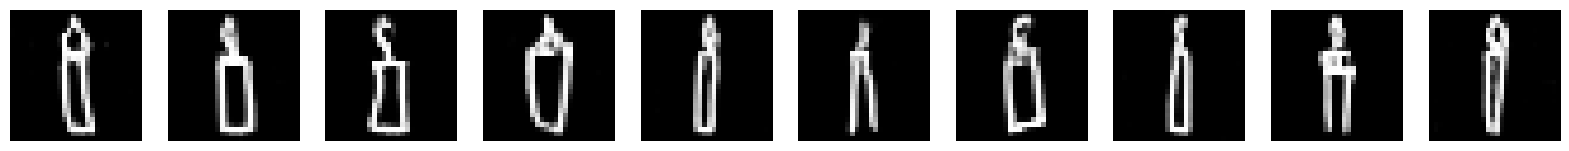

In [4]:
tf.keras.backend.clear_session()
train(train_ds, EPOCHS)

C:\Users\Benny\AppData\Local\Temp\ipykernel_6204\475315432.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\Benny\AppData\Local\Temp\ipykernel_6204\475315432.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



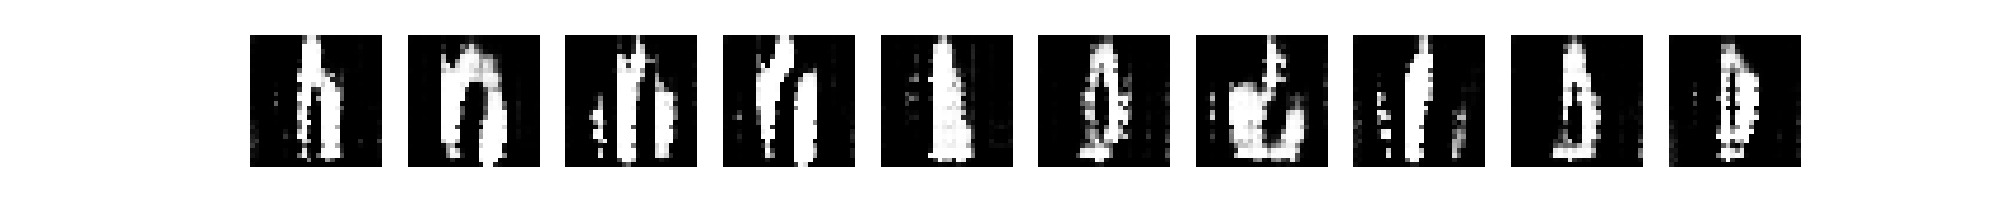

In [5]:
# make GIF from generated images
anim_file = 'candle.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

embed.embed_file(anim_file)